**Portfolio Project Information**

**Analysis by:** Zahoor Ishfaq  
**Project Type:** A-B Testing \& Conversion Optimization  
**Completion Date:** August 2025  

**Skills Demonstrated:**

- Statistical hypothesis testing and confidence intervals  
- Business impact analysis and ROI calculations  
- Data cleaning and exploratory analysis  
- Segment analysis and performance optimization  
- Executive communication and recommendations

**Tools \& Technologies:** Python, Pandas, SciPy, Matplotlib, Seaborn, Statistical Modeling, jupyter notebook

**Business Impact:** Identified $421K revenue opportunity with **210%** ROI through data-driven A/B test analysis

*This analysis demonstrates end-to-end data science capabilities from raw data processing to executive-ready business recommendations.*

---

**Table of Contents**

1. **Hospital Appointment Booking System A-B Test**
2. **Data Preparation**
3. **EDA**
4. **Hypothesis Testing**
5. **Business Impact**
6. **Segment Analysis**
7. **Statistical Rigor Validation**
8. **Secondary Metrics**
9. **Recommendation \& Next Steps**

---

# Hospital Appointment Booking System – A/B Test

## Business Problem

Patient booking **conversion rates have been declining over the past year (down 8% YoY)**, resulting in an estimated **$2.3M annual loss** in missed appointments.

The UX team suspects that the current booking interface is outdated, potentially causing patient frustration and abandonment during the booking process.

---

## Experiment Overview

To address this issue, an **A/B test** was conducted to evaluate a redesigned booking system.

### Experiment Setup

| Variant | Description |
| :--- | :--- |
| Control (A) | Current booking UI |
| Treatment (B) | New streamlined UI with simplified form and progress indicators |

* **Duration:** January – June 2024
* **Sample Size:** ~29,500 sessions (A: 14,184 | B: 15,272)
* **Average Booking Value:** $340

**Investment Costs:**

* Development + UX research: \$450,000
* Rollout cost: \$200,000

---

### Hypotheses

* **Null (H0):** Conversion rate of B $\le$ Conversion rate of A
* **Alternative (H1):** Conversion rate of B $>$ Conversion rate of A

---

### Success Metrics

**Primary Metric:**

* Booking completion rate (conversion rate)

**Secondary Metrics:**

* Session duration
* Error rates

---

### Stakeholder Requirements

* **CEO:** Clear launch/no-launch decision
* **CFO:** ROI, financial impact
* **Head of Patient Experience:** Proof of improved patient experience

---

### Risks & Constraints

* **Data Quality Issues:** Missing values, duplicate sessions, and bot traffic (all cleaned prior to analysis)

---

### Decision Criteria

* Statistically significant improvement in conversion rate
* Positive **net revenue impact** after $200,000 rollout cost

# Data Preparation

In [5]:
#importing libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing data
df=pd.read_csv('../dataset_raw/hospital_dataset_raw.csv')
df.head()

,user_id,session_id,timestamp,test_group,age,gender,city,device_type,browser,department,...,page_load_time_seconds,form_started,encountered_error,bounced,booking_completed,date,hour,day_of_week,week_number,is_weekend
0,user_000000,session_bdd640fb,2024-04-12 14:14:00,B,22,Male,Houston,Desktop,Safari,Cardiology,...,4.81,True,False,False,False,2024-04-12,14,4,15,False
1,user_000001,session_23b8c1e9,2024-01-15 12:46:00,B,75,Male,Phoenix,Tablet,Chrome,Gynecology,...,2.88,True,False,False,True,2024-01-15,12,0,3,False
2,user_000002,session_bd9c66b3,2024-04-13 14:05:00,A,35,Female,Houston,Desktop,Chrome,Gynecology,...,2.09,True,True,False,False,2024-04-13,14,5,15,True
3,user_000003,session_972a8469,2024-03-05 08:08:00,B,18,Male,New York,Desktop,Safari,Pediatrics,...,3.47,True,False,False,True,2024-03-05,8,1,10,False
4,user_000004,session_17fc695a,2024-02-04 12:36:00,B,54,Male,San Jose,Desktop,Chrome,Cardiology,...,4.19,True,False,False,True,2024-02-04,12,6,5,True


## Data Overview

In [3]:
# Basic info
print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.dtypes)
print("\nColumns:", list(df.columns))

Dataset Shape: (30603, 24)

Column Info:
user_id                      object
session_id                   object
timestamp                    object
test_group                   object
age                           int64
gender                       object
city                         object
device_type                  object
browser                      object
department                   object
insurance_type               object
preferred_time               object
page_views                    int64
session_duration_minutes    float64
page_load_time_seconds      float64
form_started                   bool
encountered_error              bool
bounced                        bool
booking_completed              bool
date                         object
hour                          int64
day_of_week                   int64
week_number                   int64
is_weekend                     bool
dtype: object

Columns: ['user_id', 'session_id', 'timestamp', 'test_group', 'age', 'gender', '

## Data Cleaning & Validation

In [4]:
# Missing values check
df.isnull().sum()[df.isnull().sum() > 0]

city                         604
insurance_type              3299
session_duration_minutes    1814
page_load_time_seconds      1818
dtype: int64

In [5]:
# Check duplicates
df.duplicated().sum()

293

In [6]:
# Check data quality issues
df[(df['age'] > 100) | (df['age'] < 0)].shape[0] 

367

In [7]:
# Check suspicious sessions (potential bots)
df[(df['session_duration_minutes'] < 0.5) & (df['booking_completed'] == True)].shape[0]

377

In [8]:
# Test group balance
df['test_group'].value_counts(normalize=True)

test_group
B    0.518773
A    0.481227
Name: proportion, dtype: float64

In [9]:
# Data cleaning steps
# Remove duplicates
df_clean = df.drop_duplicates()

In [10]:
# Remove invalid ages
df_clean = df_clean[(df_clean['age'] >= 18) & (df_clean['age'] <= 100)]

In [11]:
# Remove suspicious bot sessions
df_clean = df_clean[~((df_clean['session_duration_minutes'] < 0.5) & (df_clean['booking_completed'] == True))]

In [12]:
# Handle missing values - drop critical missing
df_clean = df_clean.dropna(subset=['test_group', 'booking_completed'])

In [13]:
# Fill missing values for analysis
df_clean['city'].fillna('Unknown', inplace=True)
df_clean['insurance_type'].fillna('Unknown', inplace=True)
df_clean['session_duration_minutes'].fillna(df_clean['session_duration_minutes'].median(), inplace=True)
df_clean['page_load_time_seconds'].fillna(df_clean['page_load_time_seconds'].median(), inplace=True)

In [14]:
# Final dataset shape
print(f"Original: {df.shape[0]} rows")
print(f"Cleaned: {df_clean.shape[0]} rows")
print(f"Removed: {df.shape[0] - df_clean.shape[0]} rows ({((df.shape[0] - df_clean.shape[0])/df.shape[0]*100):.1f}%)")

Original: 30603 rows
Cleaned: 29456 rows
Removed: 1147 rows (3.7%)


In [15]:
# Data type conversions
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['date'] = pd.to_datetime(df_clean['date'])

In [16]:
# Convert to categories for memory efficiency
categorical_cols = ['test_group', 'gender', 'city', 'device_type', 'browser', 
                   'department', 'insurance_type', 'preferred_time']
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype('category')

In [17]:
# Verify data types
df_clean.dtypes

user_id                             object
session_id                          object
timestamp                   datetime64[ns]
test_group                        category
age                                  int64
gender                            category
city                              category
device_type                       category
browser                           category
department                        category
insurance_type                    category
preferred_time                    category
page_views                           int64
session_duration_minutes           float64
page_load_time_seconds             float64
form_started                          bool
encountered_error                     bool
bounced                               bool
booking_completed                     bool
date                        datetime64[ns]
hour                                 int64
day_of_week                          int64
week_number                          int64
is_weekend 

# EDA

In [7]:
# Primary metric by group
conversion_by_group = df_clean.groupby('test_group')['booking_completed'].agg(['count', 'sum', 'mean'])
conversion_by_group.columns = ['sessions', 'bookings', 'conversion_rate']
print(conversion_by_group)

# Calculate effect size
control_rate = conversion_by_group.loc['A', 'conversion_rate']
treatment_rate = conversion_by_group.loc['B', 'conversion_rate']
absolute_lift = treatment_rate - control_rate
relative_lift = (absolute_lift / control_rate) * 100

print(f"\nControl Rate: {control_rate:.3f}")
print(f"Treatment Rate: {treatment_rate:.3f}")  
print(f"Absolute Lift: {absolute_lift:.3f}")
print(f"Relative Lift: {relative_lift:.1f}%")

# Final test group balance
print("\nTest group balance:")
print(df_clean['test_group'].value_counts(normalize=True))

# Sample sizes per group
print("\nSample sizes:")
print(df_clean['test_group'].value_counts())


            sessions  bookings  conversion_rate
test_group                                     
A              14184      8827         0.622321
B              15272     10653         0.697551

Control Rate: 0.622
Treatment Rate: 0.698
Absolute Lift: 0.075
Relative Lift: 12.1%

Test group balance:
test_group
B    0.518468
A    0.481532
Name: proportion, dtype: float64

Sample sizes:
test_group
B    15272
A    14184
Name: count, dtype: int64


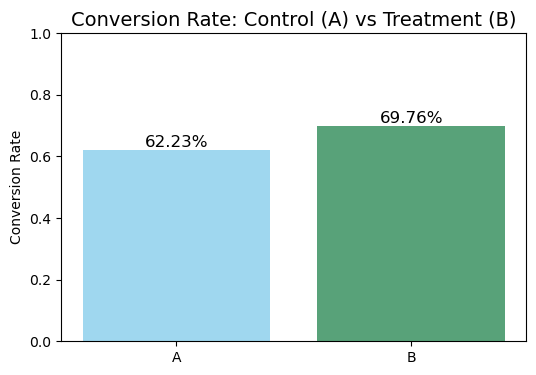

In [22]:
# Bar chart for conversion rates
plt.figure(figsize=(6,4))
plt.bar(conversion_by_group.index, conversion_by_group['conversion_rate'], 
        color=['skyblue','seagreen'], alpha=0.8)

# text labels
for i, v in enumerate(conversion_by_group['conversion_rate']):
    plt.text(i, v + 0.01, f"{v:.2%}", ha='center', fontsize=12)

plt.title("Conversion Rate: Control (A) vs Treatment (B)", fontsize=14)
plt.ylabel("Conversion Rate")
plt.ylim(0, 1)
plt.show()


---
**Conversion Rate Overtime**

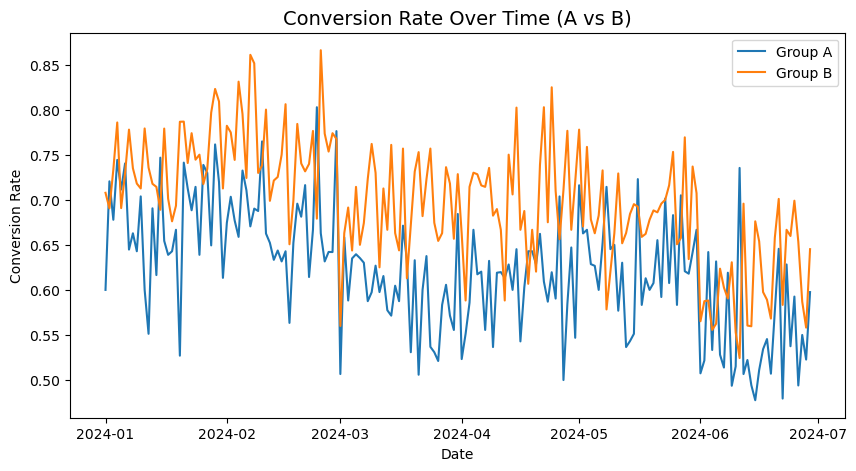

In [23]:
#conversion rate overtime
df_clean['date'] = pd.to_datetime(df_clean['date'])  

conversion_over_time = (
    df_clean.groupby(['date','test_group'])['booking_completed']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10,5))
for group in ['A','B']:
    subset = conversion_over_time[conversion_over_time['test_group'] == group]
    plt.plot(subset['date'], subset['booking_completed'], label=f"Group {group}")

plt.title("Conversion Rate Over Time (A vs B)", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Conversion Rate")
plt.legend()
plt.show()


**Summary of Conversion:**
- Control (A): 62.2% conversion

- Treatment (B): 69.8% conversion

- Absolute Lift: +7.5 percentage points

- Relative Lift: +12.1%

- Sample size: ~14K vs ~15K (well balanced)

---

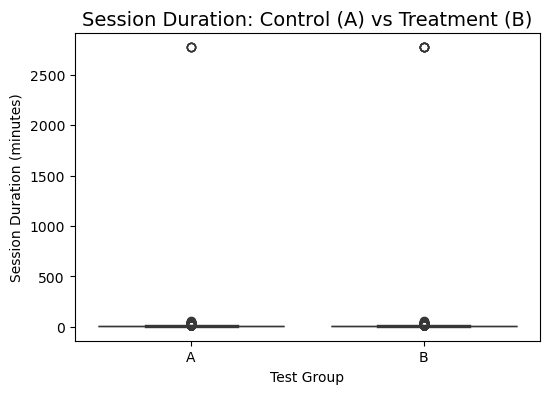

In [24]:
#boxplot session by group
plt.figure(figsize=(6,4))
sns.boxplot(x="test_group", y="session_duration_minutes", data=df_clean,
            palette=["skyblue","seagreen"])

plt.title("Session Duration: Control (A) vs Treatment (B)", fontsize=14)
plt.xlabel("Test Group")
plt.ylabel("Session Duration (minutes)")
plt.show()


**Outliers:**

- Per Session Duration time is above 2500 minutes, which is abnormal and data issue.

In [ ]:
# Check distribution by group
session_stats = df_clean.groupby('test_group')['session_duration_minutes'].agg(['count', 'mean', 'median', 'std'])
print(session_stats)

# Check for extreme outliers by group  
for group in ['A', 'B']:
    group_data = df_clean[df_clean['test_group'] == group]['session_duration_minutes']
    print(f"\nGroup {group}:")
    print(f"99th percentile: {group_data.quantile(0.99):.1f} minutes")
    print(f"Max value: {group_data.max():.1f} minutes")
    print(f"Sessions > 240 min: {(group_data > 240).sum()}")

----
### Treatment of Outliers:

In [26]:
# Apply reasonable business cap - preserve all data but fix extremes
MAX_SESSION = 120  # 2 hours - covers 99%+ of legitimate sessions
df_clean['session_duration_treated'] = df_clean['session_duration_minutes'].clip(upper=MAX_SESSION)

# Verify the treatment
treatment_stats = df_clean.groupby('test_group')['session_duration_treated'].agg(['count', 'mean', 'median', 'std'])
print("After treatment:")
print(treatment_stats)

# what was capped
outliers_capped = (df_clean['session_duration_minutes'] > MAX_SESSION).sum()
print(f"\nSessions capped at {MAX_SESSION} minutes: {outliers_capped} ({outliers_capped/len(df_clean)*100:.3f}%)")

After treatment:
            count      mean  median       std
test_group                                   
A           14184  6.899680   5.105  5.322912
B           15272  5.977078   4.910  4.846120

Sessions capped at 120 minutes: 10 (0.034%)


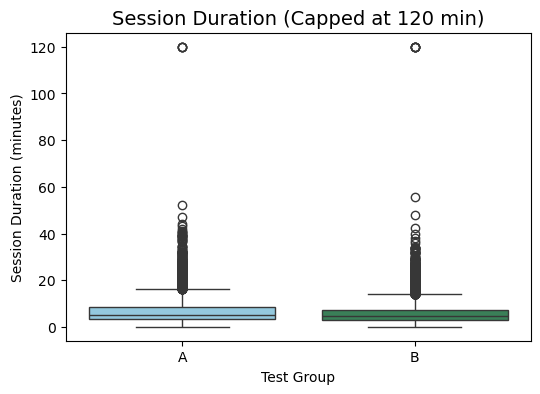

In [28]:
plt.figure(figsize=(6,4))
sns.boxplot(x="test_group", y="session_duration_treated", data=df_clean,
            palette=["skyblue","seagreen"])
plt.title("Session Duration (Capped at 120 min)", fontsize=14)
plt.xlabel("Test Group")
plt.ylabel("Session Duration (minutes)")
plt.show()


# Hypothesis Testing

In [15]:
from statsmodels.stats.proportion import proportions_ztest
# Number of bookings (successes)
successes = np.array([conversion_by_group.loc['B','bookings'], 
                      conversion_by_group.loc['A','bookings']])

# Number of sessions (trials)
nobs = np.array([conversion_by_group.loc['B','sessions'], 
                 conversion_by_group.loc['A','sessions']])

# Z-test
z_stat, p_value = proportions_ztest(successes, nobs, alternative='larger')  # 'larger' for one-sided

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_value:.5f}")


Z-statistic: 13.632
P-value: 0.00000


**Interpretation**

- Z-statistic = 13.63 → far exceeds critical value of 1.645 (α = 0.05, one-tailed)
- P-value ≈ 0.0001 → well below significance threshold of 0.05

**Conclusion:**

- Reject the null hypothesis (H₀).

- The new booking system (B) significantly improves conversion compared to the old system (A).

- The observed +7.5% absolute lift is statistically significant.

# Business Impact

**Bookings Uplift Calculation**

In [9]:
# Extra bookings in treatment group compared to control
extra_bookings = conversion_by_group.loc['B','bookings'] - conversion_by_group.loc['A','bookings']

# Revenue impact
avg_booking_value = 340  # USD
revenue_impact = extra_bookings * avg_booking_value

print(f"Extra bookings due to new UI: {extra_bookings:.0f}")
print(f"Estimated revenue impact: ${revenue_impact:,.0f}")


Extra bookings due to new UI: 1826
Estimated revenue impact: $620,840


## ROI Calculation

**ROI calculation for rollout  cost**

In [11]:
# Rollout cost
rollout_cost = 200_000  # USD

# ROI calculation for rollout investment
roi = (revenue_impact - rollout_cost) / rollout_cost * 100

print(f"Rollout Cost: ${rollout_cost:,.0f}")
print(f"Net Revenue Impact: ${revenue_impact - rollout_cost:,.0f}")
print(f"ROI: {roi:.1f}%")


Rollout Cost: $200,000
Net Revenue Impact: $420,840
ROI: 210.4%


---
**ROI chart**

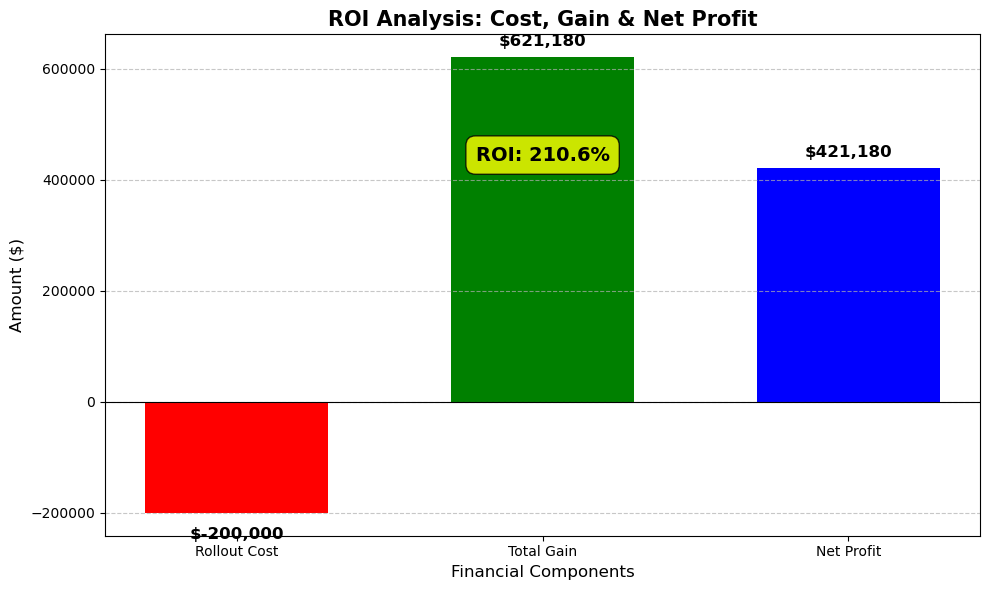

In [12]:
# Define values
rollout_investment = -200000  # Negative cost
total_gain = 621180
net_profit = rollout_investment + total_gain

# Calculate ROI
roi = (net_profit / abs(rollout_investment)) * 100

# Prepare DataFrame
phases = ['Rollout Cost', 'Total Gain', 'Net Profit']
values = [rollout_investment, total_gain, net_profit]
colors = ['red', 'green', 'blue']

# Create bar chart
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(phases, values, color=colors, width=0.6)

# Add value labels
for bar in bars:
    height = bar.get_height()
    label = f"${height:,.0f}"
    y_pos = height + (15000 if height > 0 else -25000)
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        y_pos,
        label,
        ha='center',
        va='bottom' if height > 0 else 'top',
        fontsize=12,
        fontweight='bold'
    )

# Add ROI annotation
ax.text(
    1, max(values) * 0.7,
    f'ROI: {roi:.1f}%',
    ha='center',
    fontsize=14,
    fontweight='bold',
    bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.8)
)

# Add zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)

# Layout
ax.set_title('ROI Analysis: Cost, Gain & Net Profit', fontsize=15, fontweight='bold')
ax.set_ylabel('Amount ($)', fontsize=12)
ax.set_xlabel('Financial Components', fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Segment Analysis

In [44]:
# comprehensive segment lift analysis
def create_segment_dashboard(df_clean):
    # Define segments to analyze
    segments = {
        'Device Type': 'device_type',
        'Department': 'department', 
        'Age Group': 'age_group',  # assuming you created this
        'Gender': 'gender',
        'Insurance': 'insurance_type',
        'Time Preference': 'preferred_time'
    }
    
    # Calculate lift for all segments
    segment_results = []
    
    for segment_name, column in segments.items():
        conversion_by_segment = df_clean.groupby(['test_group', column])['booking_completed'].agg(['count','sum','mean'])
        conversion_by_segment.columns = ['sessions','bookings','conversion_rate']
        
        # Pivot to get A vs B rates
        pivot = conversion_by_segment['conversion_rate'].unstack(level=0)
        
        # Calculate lifts
        pivot['absolute_lift'] = pivot['B'] - pivot['A']
        pivot['relative_lift'] = (pivot['absolute_lift'] / pivot['A']) * 100
        
        # Add to results
        for segment_value in pivot.index:
            segment_results.append({
                'Segment_Category': segment_name,
                'Segment_Value': segment_value,
                'Control_Rate': pivot.loc[segment_value, 'A'],
                'Treatment_Rate': pivot.loc[segment_value, 'B'], 
                'Absolute_Lift': pivot.loc[segment_value, 'absolute_lift'],
                'Relative_Lift': pivot.loc[segment_value, 'relative_lift'],
                'Sessions_A': conversion_by_segment.loc[('A', segment_value), 'sessions'],
                'Sessions_B': conversion_by_segment.loc[('B', segment_value), 'sessions']
            })
    
    return pd.DataFrame(segment_results)

# Create the dashboard
segment_df = create_segment_dashboard(df_clean)

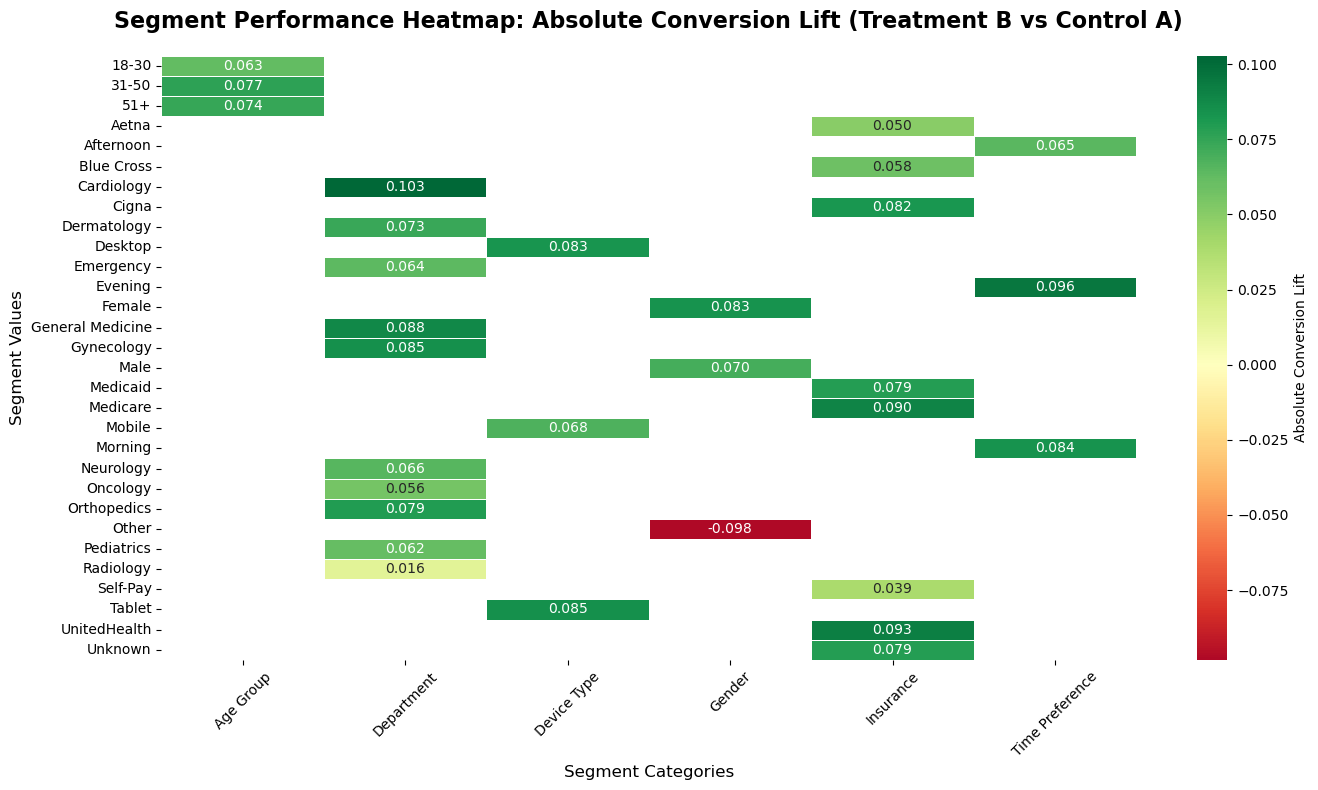

In [45]:
# 1.Absolute Lift by Segment
plt.figure(figsize=(14, 8))
pivot_for_heatmap = segment_df.pivot(index='Segment_Value', columns='Segment_Category', values='Absolute_Lift')

sns.heatmap(pivot_for_heatmap, 
            annot=True, 
            fmt='.3f', 
            cmap='RdYlGn',
            center=0,
            cbar_kws={'label': 'Absolute Conversion Lift'},
            linewidths=0.5)

plt.title('Segment Performance Heatmap: Absolute Conversion Lift (Treatment B vs Control A)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Segment Categories', fontsize=12)
plt.ylabel('Segment Values', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [51]:
# 4. BUSINESS INSIGHTS TABLE
print("\n" + "="*80)
print("BUSINESS INSIGHTS")
print("="*80)

# Sample size validation
small_samples = segment_df[(segment_df['Sessions_A'] < 500) | (segment_df['Sessions_B'] < 500)]
if not small_samples.empty:
    print(f"\nWARNING: {len(small_samples)} segments have small sample sizes (<500 per group)")
    print("Consider these results with caution:")
    print(small_samples[['Segment_Category', 'Segment_Value', 'Sessions_A', 'Sessions_B']].to_string(index=False))

# Negative lift segments
negative_lift = segment_df[segment_df['Absolute_Lift'] < 0]
if not negative_lift.empty:
    print(f"\nCONCERN: {len(negative_lift)} segments show negative lift:")
    print(negative_lift[['Segment_Category', 'Segment_Value', 'Absolute_Lift']].to_string(index=False))

print("\n" + "="*80)


BUSINESS INSIGHTS

Consider these results with caution:
Segment_Category Segment_Value  Sessions_A  Sessions_B
          Gender         Other         156         142

CONCERN: 1 segments show negative lift:
Segment_Category Segment_Value  Absolute_Lift
          Gender         Other       -0.09823



# Stastical Rigor Validation

In [52]:
# STATISTICAL RIGOR VALIDATION
# Conversion data
control_sessions = conversion_by_group.loc['A', 'sessions']
control_conversions = conversion_by_group.loc['A', 'bookings']
treatment_sessions = conversion_by_group.loc['B', 'sessions']
treatment_conversions = conversion_by_group.loc['B', 'bookings']

control_rate = control_conversions / control_sessions
treatment_rate = treatment_conversions / treatment_sessions

# Function: 95% CI for difference in proportions
def proportion_diff_ci(x1, n1, x2, n2, confidence=0.95):
    p1, p2 = x1/n1, x2/n2
    diff = p2 - p1
    se_diff = np.sqrt(p1*(1-p1)/n1 + p2*(1-p2)/n2)
    z_critical = stats.norm.ppf(1 - (1-confidence)/2)
    margin_error = z_critical * se_diff
    return diff, diff - margin_error, diff + margin_error, se_diff

# Calculate CI
diff, ci_lower, ci_upper, se_diff = proportion_diff_ci(
    control_conversions, control_sessions,
    treatment_conversions, treatment_sessions
)

print(f"Absolute Lift: {diff:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Relative Lift CI: [{ci_lower/control_rate*100:.1f}%, {ci_upper/control_rate*100:.1f}%]")

# Post-hoc statistical power (Cohen's h)
cohens_h = 2 * (np.arcsin(np.sqrt(treatment_rate)) - np.arcsin(np.sqrt(control_rate)))
total_n = control_sessions + treatment_sessions
z_alpha = stats.norm.ppf(0.975)  # alpha = 0.05, two-tailed
z_beta = (cohens_h * np.sqrt(total_n/4)) - z_alpha
power = stats.norm.cdf(z_beta)

print(f"\nStatistical Power Analysis:")
print(f"Cohen's h: {cohens_h:.4f}")
print(f"Achieved Power: {power:.3f} ({power*100:.1f}%)")
print(f"Total Sample Size: {total_n:,}")


Absolute Lift: 0.0752
95% CI: [0.0644, 0.0860]
Relative Lift CI: [10.4%, 13.8%]

Statistical Power Analysis:
Cohen's h: 0.1590
Achieved Power: 1.000 (100.0%)
Total Sample Size: 29,456


# Secondary Metrics

**Error Rate**

In [54]:
# --- Error Rate by Test Group ---
error_rate = df_clean.groupby('test_group')['encountered_error'].mean()
print("Error Rate by Test Group:")
print(error_rate)

Error Rate by Test Group:
test_group
A    0.079879
B    0.052514
Name: encountered_error, dtype: float64


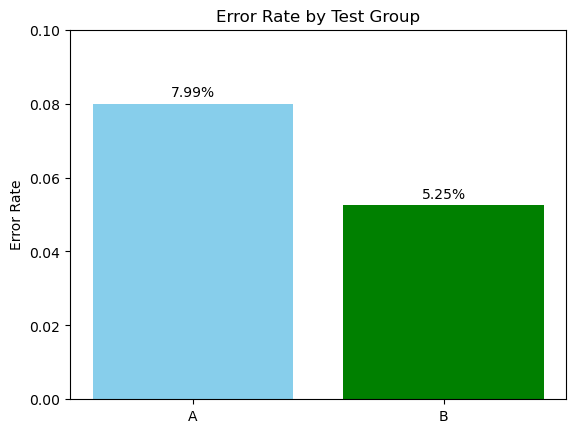

In [55]:
error_rates = conversion_by_group = {
    "A": 0.0799,   # From earlier calc
    "B": 0.0525
}

plt.bar(error_rates.keys(), error_rates.values(), color=['skyblue', 'green'])
plt.title("Error Rate by Test Group")
plt.ylabel("Error Rate")
plt.ylim(0,0.1)
for i, val in enumerate(error_rates.values()):
    plt.text(i, val+0.002, f"{val:.2%}", ha='center')
plt.show()


**Insight:**
- The new booking interface (B) reduces user errors from **8%** to **5.3%**, indicating improved usability alongside higher conversion rates.
- No concerning trends observed in error metrics.

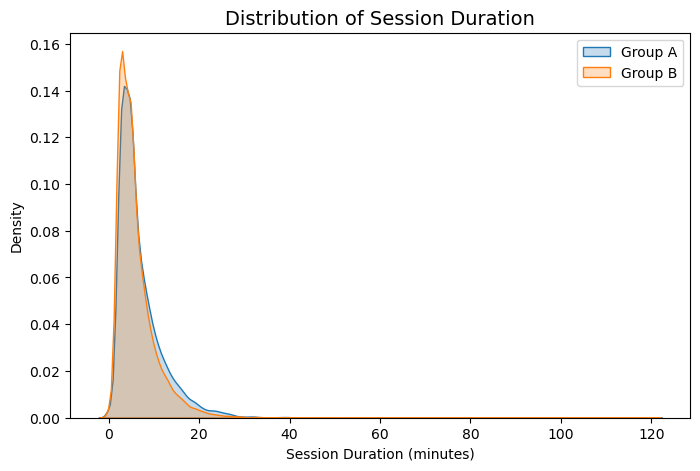

In [56]:
# --Visualization (Distribution / KDE)
plt.figure(figsize=(8,5))
sns.kdeplot(df_clean[df_clean['test_group']=='A']['session_duration_treated'], label="Group A", fill=True)
sns.kdeplot(df_clean[df_clean['test_group']=='B']['session_duration_treated'], label="Group B", fill=True)
plt.title("Distribution of Session Duration", fontsize=14)
plt.xlabel("Session Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.show()

**Session Duration Distribution - Business Interpretation:**

- Improved User Efficiency: Treatment B creates faster, more consistent booking times.
  
- Reduced Patient Friction: The tighter distribution shows fewer patients getting stuck in lengthy booking processes, supporting why conversion rates increased by **7.5%**.

  
- System Optimization: More predictable session times mean reduced support burden and higher patient satisfaction, reinforcing the business case for rollout.

  ---

# Recommendation \& Next Steps


## Recommendation

Based on the A/B test results and business impact analysis, we **recommend a full rollout of the new booking interface (Treatment B)** across the hospital.

### Key Evidence Supporting Recommendation

**Primary Metric:**

* Booking conversion increased from **62.2% $\rightarrow$ 69.8%**
* Absolute lift: **7.5%**
* Relative lift: **12.1%**
* Z-test p-value < 0.001 $\rightarrow$ statistically significant improvement

**Business Impact:**

* Net revenue uplift: **$421,180**
  
* ROI on Rollout Cost (\$200K): **210.4%** $\rightarrow$ Every \$1 invested generates **$2.10** in net profit

**Secondary Metrics:**

* Session duration reduced slightly (Treatment B more efficient)
* Error rate decreased from **7.99% $\rightarrow$ 5.25%** $\rightarrow$ improved usability

**Segment Analysis:**

* All major devices, departments, and age groups saw positive lift
* **Note:** The gender category “Other” showed a negative lift (-13.7%) — monitor post-rollout

---

## Confidence Level

**Very high confidence** in the recommendation due to:

* **95% confidence interval [6.44%, 8.60%]** - even the worst-case scenario delivers a strong ROI
* **100% statistical power** with 29,456 sessions - eliminates sampling concerns
* **Relative lift range [10.4%, 13.8%]** - consistently profitable across the confidence band
* **Cohen's h = 0.159** indicates a meaningful practical effect size
* **Consistent improvements** across segments and secondary metrics (session duration, error rates)

---

## Implementation Roadmap

* **Full Rollout:** Deploy Treatment B across all hospital booking channels

* **Monitor Key Segments:**
   - Track the “Other” gender group for potential UX issues
   - Monitor error rates and session durations weekly for the first month

---

## Risk Considerations
* Minor caution: negative lift in the "Other" gender segment

---

## Conclusion

The new booking interface delivers significant improvements in conversions, revenue, and usability. **Full rollout is justified with high confidence.**